# Evolution Plots

In [6]:
import os
import sys
from subprocess import Popen, PIPE

sys.path.append("/home/pkarpov/Sapsan")

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sapsan.utils import line_plot, slice_plot, pdf_plot, cdf_plot

#plt.style.use('default')

class routines:
    def __init__(self, x, rho, v):
        self.x = x
        self.rho = rho
        self.v = v        
        self.shock_ind = 0
        self.shock_x = 0
        self.pns_ind = 0
        self.pns_x = 0
        
    def shock_radius(self):        
        self.shock_ind = np.argmin(self.v)
        self.shock_x = self.x[self.shock_ind]
    
        #print('shock position: %.2e'%self.shock_x, self.shock_ind)
        return self.shock_ind, self.shock_x
        
    def pns_radius(self, rho_threshold = 2e11):        
        for i in range(len(self.rho)):
            if self.rho[i] > rho_threshold:
                self.pns_ind = i
                self.pns_x = self.x[i]
        return self.pns_ind, self.pns_x        

class Profiles:
    def __init__(self, numfiles, base_path, dataset, save_name_amend='', only_post_bounce = False):
        self.numfiles = numfiles
        self.lumnue = np.zeros((self.numfiles))
        self.times = np.zeros((self.numfiles))
        self.base_path = base_path
        self.dataset = dataset
        self.save_name_amend = save_name_amend
        self.only_post_bounce = only_post_bounce
        self.progress_bar(0)
        
        self.shock_ind_ar = np.zeros(self.numfiles)
        self.shock_x_ar = np.zeros(self.numfiles)
        self.pns_ind_ar = np.zeros(self.numfiles)
        self.pns_x_ar = np.zeros(self.numfiles)
        self.time_ar = np.zeros(self.numfiles)
        self.ind_ar = np.arange(self.numfiles)
        self.bounce_ind = 0
        
    def progress_bar(self, current, val='', done = False, bar_length=20):
        fraction = current / self.numfiles

        arrow = int(fraction * bar_length - 1) * '-' + '>'
        padding = int(bar_length - len(arrow)) * ' '
        padding_val = int(7-len(val)) * ' '

        ending = '\n' if done == True else '\r'

        print(f'Progress: [{arrow}{padding}] {current}/{self.numfiles}, val: {val}{padding_val}', end=ending) 

    def set_paths(self, val, versus):
        self.plot_path = f'{self.base_path}{self.dataset}/plots/{val}'
        
        if not os.path.exists(self.plot_path): os.makedirs(self.plot_path)
        if versus=='r': self.plot_file = f'{self.plot_path}/{val}_r'
        elif versus=='encm': self.plot_file = f'{self.plot_path}/{val}_encm'    

    def movie(self, val, versus='r', fps=15, start=0, printout=False):      
        self.set_paths(val,versus)
        padding_val = int(7-len(val)) * ' '
        
        if self.only_post_bounce:
            name_amend = '_bounce'
            start = self.bounce_ind
        else: name_amend = ''
            
        name = f'{self.plot_file}{self.save_name_amend}'
            
        print(f'{val}{padding_val}: {name}{name_amend}.mp4')
        result = Popen(['ffmpeg', '-r', f'{fps}', '-start_number', f'{start}',
                        '-i', f'{name}_%d.png', 
                        '-vcodec', 'libx264', f'{name}{name_amend}.mp4', '-y'],
                        stdin=PIPE, stdout=PIPE, stderr=PIPE)   
        output, error = result.communicate()
        if printout: print(output, error)       
        
    def plot_convection(self):
        ax = line_plot([[self.ind_ar, self.shock_ind_ar-self.pns_ind_ar]])
        ax.get_legend().remove()
        ax.set_xlim(self.bounce_ind,self.numfiles)
        ax.set_xlabel('index')
        ax.set_ylabel('Convection Grid Size')
        ax.set_title(f'Bounce index = {self.bounce_ind}')
        plt.tight_layout()
        plt.savefig(f'{self.plot_path}/{self.save_name_amend}convgrid.png')
        return ax
        
    def plot_profile(self, i, file, vals, versus,
                     show_plot=True, save_plot=False, 
                     compute=False, rho_threshold = 2e11):
        file1d = f'{self.base_path}{self.dataset}/{file}'                        

        with open(file1d, "r") as file:
            line = file.readline()        
            header_vals = file.readline()
            vals_strip = header_vals[:-1].split(' ')        
            time1d, pns_ind, pns_x, shock_ind, shock_x, rlumnue = [float(x) for x in vals_strip if x!='']        
            self.lumnue[i] = rlumnue
            self.times[i] = time1d    
            #print(file.readline())
            
        pns_ind = int(pns_ind)-1
        
        #change index adjustment to '-1'!
        #shock_ind = int(shock_ind)-2
        shock_ind = int(shock_ind)-1
        
        if shock_ind <= 0 and self.only_post_bounce == True: return
        
        #print('Time %.2f ms'%(float(time1d)*1e3))

        ps = np.loadtxt(file1d, skiprows=3)
        ps = np.moveaxis(ps,0,1)        
        
        for val in vals:
            if versus=='encm':
                x_ind = 1
                xlabel = r'$M_{enc} \; [M_{sol}]$'
                xlim = (0,3) #or (0,4)
                plot_type = 'semilogy'
                unit = 1        
            elif versus=='r':
                x_ind = 2
                xlabel = r'$Radius \; [km]$'
                xlim = (1e0,1e5)
                plot_type = 'loglog'
                unit = 1e-5

            #Cell M_enclosed Position Rho V Ye Pressure Temperature
            if val == 'rho': 
                ps_ind = 3
                ylabel = r'Density $[g/cm^3]$'
                ylim = (1e4,1e15)
            elif val == 'v':
                ps_ind = 4
                ylabel = r'Velocity $[cm/s]$'
                ylim = (-6e9, 2.5e9)
                if versus == 'r': plot_type = 'semilogx'
                elif versus == 'encm': plot_type = 'plot'
            elif val == 'P':
                ps_ind = 6
                ylabel = r'$P_{gas} \; [\frac{g}{cm\;s^2}]$'
                ylim = (1e20,1e36)   
            elif val == 'T':
                ps_ind = 7
                ylabel = r'Temperature $[K]$'
                ylim = (1e5,4e11)
            else: print("ERROR: unknown val, trying to exit"); sys.exit()            

            #print('diff shock', shock_ind, np.argmin(ps[4]), shock_ind-np.argmin(ps[4]))
            #shock_ind = np.argmin(ps[4])

            ax = line_plot([[ps[x_ind]*unit, ps[ps_ind]],],
                            #[ps[2,:504]*1e0, ps[ps_ind,:504]],
                           plot_type = plot_type,
                           label = [f'ind     {i+1}'],
                           linestyle=['-','--','-','--'],               
                           figsize=(10,6))    
            
            # check if after bounce                
            if shock_ind > 0:
                if self.bounce_ind == 0: self.bounce_ind = i                
                
                if compute and vals.index(val)==0:
                    rt = routines(ps[x_ind], ps[3], ps[4])
                    shock_ind, shock_x = rt.shock_radius()
                    pns_ind, pns_x = rt.pns_radius(rho_threshold = rho_threshold)   
                    
                #print(f'shock {ps[2,int(shock_ind)]:.3e}, {shock_x:.3e}')
                
                pns_edge = pns_x*unit
                shock_front = ps[x_ind,int(shock_ind)]*unit
                if versus == 'r': line_label = '%.2e km'          
                if versus == 'encm': line_label = '%.3f $M_{sol}$'               
                ax.axvline(x=pns_edge,linestyle='-',color='r',linewidth=1,
                           label=f'PNS    {line_label%pns_edge}')
                ax.axvline(x=shock_front,linestyle='--',color='r',linewidth=1,
                           label=f'shock {line_label%shock_front}')
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.set_title('$t_{1d}=$%.2f ms'%(float(time1d)*1e3))

            plt.legend()
            plt.tight_layout()
            if save_plot:
                self.set_paths(val, versus)                
                plt.savefig(f'{self.plot_file}{self.save_name_amend}_{i+1}.png')
                
            if not show_plot: plt.close()
            
            if vals.index(val)==0:
                self.shock_ind_ar[i] = shock_ind
                self.shock_x_ar[i] = shock_x
                self.pns_ind_ar[i] = pns_ind
                self.pns_x_ar[i] = pns_x
                self.time_ar[i] = time1d 
            
            done=True if (i==self.numfiles and vals.index(val)==(len(vals)-1)) else False
            self.progress_bar(i+1, val, done = done)          
        return

In [8]:
%matplotlib inline

vals = [
        'rho', 
        'v',
        'P',
        'T',
       ]
base_path = '/home/pkarpov/collapso1d/project/1dmlmix/output/'
dataset = 's12.0_4k'
save_name_amend = ''

numfiles = len([filename for filename in os.listdir(f'{base_path}{dataset}') if f'{dataset}_read' in filename])
#numfiles = 235+10
pf = Profiles(numfiles = numfiles, base_path = base_path, dataset = dataset, 
              save_name_amend=save_name_amend, only_post_bounce = True)

for i in range(numfiles):  
    #i = 247 #hrg looks good! from 50 cells to 300+ while res diffs from ~1800 to ~3600
    #versus can be either 'r' or 'encm'
    pf.plot_profile(i = i, file = f'{pf.dataset}_read.{i+1}',
                    vals = vals, versus = 'r', 
                    show_plot=False, 
                    save_plot=True,
                    compute = False,
                    rho_threshold = 1e13,
                   )
    #break     

: 

In [ ]:
ax = pf.plot_convection()
for val in vals: pf.movie(val,fps=2)  

# Legacy

In [11]:
#%matplotlib inline
%matplotlib auto

%matplotlib inline
import os
import sys

sys.path.append("../../../")

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sapsan.utils.plot import line_plot
#Cell M_enclosed Position Rho V Ye Pressure Temperature
numfiles = 400#2284
lumnue = np.zeros((numfiles))
times = np.zeros((numfiles))

#for i in range(226,numfiles):  
for i in range(numfiles):  
    #i = 390
    #file1d = '/home/pkarpov/1dccsn/project/1dmlmix/output/s19.0_hr/DataOut_s19.0_hr_readable.%d'%(i+1)
    file1d = '/home/pkarpov/1dccsn/project/1dmlmix/output/s19.0_run4/DataOut_s19.0_readable.%d'%(i+1)
    with open(file1d, "r") as file:
        line = file.readline()        
        vals = file.readline()
        vals_strip = vals[:-1].split(' ')        
        time1d, shock_ind, shock_r, rlumnue = [float(x) for x in vals_strip if x!='']           
        lumnue[i] = rlumnue
        times[i] = time1d    
        #print(file.readline())
        #sys.exit()

    print('Time %.2f ms'%(float(time1d)*1e3))
    #continue

    ps = np.loadtxt(file1d, skiprows=3)
    ps = np.moveaxis(ps,0,1)
    
    shock_ind = np.argmin(ps[4])

    ps_ind = 4
    ax = line_plot([[ps[1], ps[ps_ind]],],
                    #[ps[2,:504]*1e0, ps[ps_ind,:504]],                    
                   #plot_type='semilogy',
                   #plot_type='semilogx',
                   plot_type='plot',
                   #plot_type='loglog',
                   label = [f'ind    {i+1}'],
                   linestyle=['-','--','-','--'],               
                   figsize=(10,6))    
    if float(time1d) >= 0.2397:
        edgerho = 2e11
        edger=0
        lenrho = len(ps[3])-1
        for j in range(lenrho):
            if ps[3,lenrho-j]>edgerho:
                edgeenc = ps[1,lenrho-j]
                edger = ps[2,lenrho-j]
                break
        print('shock', ps[1,int(shock_ind)])
        ax.axvline(x=edgeenc,linestyle='-',color='r',linewidth=1, label = 'PNS %.3f $M_{sol}$'%edgeenc)
        #ax.axvline(x=edger*1e-5,linestyle='-',color='r',linewidth=1, 
        #           label = 'PNS    %.2e km'%(edger*1e-5))
        ax.axvline(x=ps[1,int(shock_ind)],linestyle='--',color='r',
                   linewidth=2, label = 'shock %.3f $M_{sol}$'%(ps[1,int(shock_ind)]))
    ax.set_xlabel(r'$M_{enc} \; [M_{sol}]$')
    #ax.set_xlabel(r'$Radius \; [cm]$')
    #ax.set_xlabel(r'$Radius \; [km]$')
    #ax.set_ylabel(r'$P_{gas} \; [\frac{g}{cm\;s^2}]$')
    ax.set_ylabel(r'Velocity $[cm/s]$')
    #ax.set_ylabel(r'Density $[g/cm^3]$')
    ax.set_title('$t_{1d}=$%.2f ms'%(float(time1d)*1e3))
    ax.set_xlim((0,3)) #M_enc
    ax.set_ylim((-5e9, 1.5e9)) #velocity
    #ax.set_xlim((1e4,1e10)) #radius in cm
    #ax.set_xlim((1e0,1e5)) #radius in km
    #ax.set_xlim((0,4)) #M_enc 2
    #ax.set_ylim((1e20,1e36)) #pressure
    #ax.set_ylim((1e4,1e15)) #density

    plt.legend()
    plt.tight_layout()
    plt.savefig('/home/pkarpov/scratch/plots/s19.0/velocity/velocity_encm%d.png'%(i+1))
    plt.close()
    #break#if i == 255: break

Using matplotlib backend: <object object at 0x7fdef67f9390>


FileNotFoundError: [Errno 2] No such file or directory: '/home/pkarpov/1dccsn/project/1dmlmix/output/s19.0_run4/DataOut_s19.0_readable.1'

pns shock 382 406 24
pns shock 420 432 12
pns shock 456 458 2
pns shock 513 515 2
pns shock 632 637 5
pns shock 710 747 37
pns shock 710 819 109
pns shock 691 879 188
pns shock 698 917 219
pns shock 527 945 418
pns shock 671 969 298
pns shock 687 987 300
pns shock 710 1000 290
pns shock 710 1011 301
pns shock 710 1019 309
pns shock 802 1027 225
pns shock 897 1033 136
pns shock 932 1039 107
pns shock 961 1043 82
pns shock 1009 1047 38
pns shock 1034 1051 17
pns shock 1032 1056 24
pns shock 1032 1061 29
pns shock 1023 1065 42
pns shock 1005 1069 64
pns shock 1039 1071 32
pns shock 1033 1073 40
pns shock 1027 1076 49
pns shock 1026 1078 52
pns shock 1030 1079 49
pns shock 1029 1080 51
pns shock 1026 1081 55
pns shock 1027 1081 54
pns shock 1029 1082 53
pns shock 1033 1082 49
pns shock 1031 1083 52
pns shock 1032 1084 52
pns shock 1030 1085 55
pns shock 1030 1085 55
pns shock 1031 1086 55
pns shock 1032 1087 55
pns shock 1034 1087 53
pns shock 1035 1088 53
pns shock 1034 1089 55
pns shock 

(240.0, 320.0)

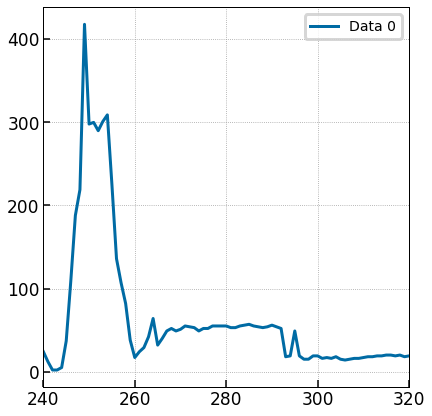

In [ ]:
%matplotlib inline
#%matplotlib auto

%matplotlib inline
import os
import sys

sys.path.append("../../../")

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sapsan.utils.plot import line_plot
#Cell M_enclosed Position Rho V Ye Pressure Temperature
#numfiles = 396 #run4 2284
numfiles = 360 # hrg
start = 226
lumnue = np.zeros((numfiles))
times = np.zeros((numfiles))
conv_region = []
bounce_ind = -1
for i in range(start,numfiles):  
    #i = 390
    #file1d = '/home/pkarpov/1dccsn/project/1dmlmix/output/s19.0_hr/DataOut_s19.0_hr_readable.%d'%(i+1)
    #file1d = '/home/pkarpov/1dccsn/project/1dmlmix/output/s19.0_run4/DataOut_s19.0_readable.%d'%(i+1)
    file1d = '/home/pkarpov/1dccsn/project/1dmlmix/output/s19.0_hrg/DataOut_readable.%d'%(i+1)
    with open(file1d, "r") as file:
        line = file.readline()        
        vals = file.readline()
        vals_strip = vals[:-1].split(' ')        
        time1d, shock_ind, shock_r, rlumnue = [float(x) for x in vals_strip if x!='']   
        lumnue[i] = rlumnue
        times[i] = time1d    
        #print(file.readline())
        #sys.exit()

    #print('Time %.2f ms'%(float(time1d)*1e3))
    #continue

    ps = np.loadtxt(file1d, skiprows=3)
    ps = np.moveaxis(ps,0,1)
    
    shock_ind = np.argmin(ps[4])

    ps_ind = 4
       
    if float(time1d) >= 0.2397:
        if bounce_ind == -1: bounce_ind = i
        edgerho = 2e11
        edger=0
        lenrho = len(ps[3])-1
        for j in range(lenrho):
            if ps[3,lenrho-j]>edgerho:
                edgeenc = ps[1,lenrho-j]
                edger = ps[2,lenrho-j]
                break
        conv_region.append(int(shock_ind)-(lenrho-j))
        print('pns shock', lenrho-j, int(shock_ind), int(shock_ind)-(lenrho-j)) 
ax = line_plot([[times[bounce_ind:i+1]*1000, conv_region]])
ax.set_xlim((240,320))

Text(0.5, 1.0, 'Grid Size: 3667')

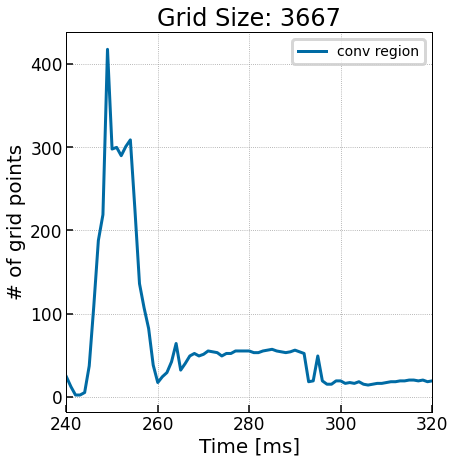

In [13]:
ax = line_plot([[times[bounce_ind:i+1]*1000, conv_region]], label=['conv region'])
ax.set_xlim((240,320))
ax.set_xlabel('Time [ms]')
ax.set_ylabel('# of grid points')
ax.set_title('Grid Size: 3667')